In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing;
import math, time, itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os
from sklearn import linear_model;
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from pandas_datareader import data
# import urllib.request, json
import tensorflow as tf 
# import io
# import pdb
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
Company_select='FORD MOTOR CO'
ticker_symbol='F'

In [63]:
df = pd.read_csv("./dataset/prices-split-adjusted.csv", index_col = 0)

In [81]:
df.head()
df = df[df['symbol'] == 'SYMC']
df['Mid']=(df['high']+df['low'])/2
df.sort_values(by='date',inplace=True)

In [82]:
def prepare_data(df,forecast_col,forecast_out,test_size):
    label = df[forecast_col].shift(-forecast_out);
    X = np.array(df[[forecast_col]]); 
    X = preprocessing.scale(X) 
    X_lately = X[-forecast_out:] 
    X = X[:-forecast_out] 
    label.dropna(inplace=True); 
    y = np.array(label) 
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y, test_size=test_size) #cross validation 

    response = [X_train,X_test , Y_train, Y_test , X_lately];
    return response;

In [83]:
df.head()

,symbol,open,close,low,high,volume,Mid
date,,,,,,,
2010-01-04,SYMC,18.040001,18.400000,18.010000,18.530001,8322300.0,18.270001
2010-01-05,SYMC,18.400000,18.299999,18.139999,18.440001,6621200.0,18.290000
2010-01-06,SYMC,18.219999,18.360001,18.139999,18.459999,6043600.0,18.299999
2010-01-07,SYMC,18.469999,18.320000,18.129999,18.469999,8085300.0,18.299999
2010-01-08,SYMC,18.250000,18.370001,18.209999,18.500000,6030900.0,18.354999


In [84]:
target_col = 'Mid'
predict_window = 20
test_size = 0.2;

X_train, X_test, Y_train, Y_test , X_lately =prepare_data(df, target_col, predict_window, test_size); 

linear_reg_model = linear_model.LinearRegression(); 

In [85]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1393, 1)
(349, 1)
(1393,)
(349,)


The test score is:  0.8745056962691475


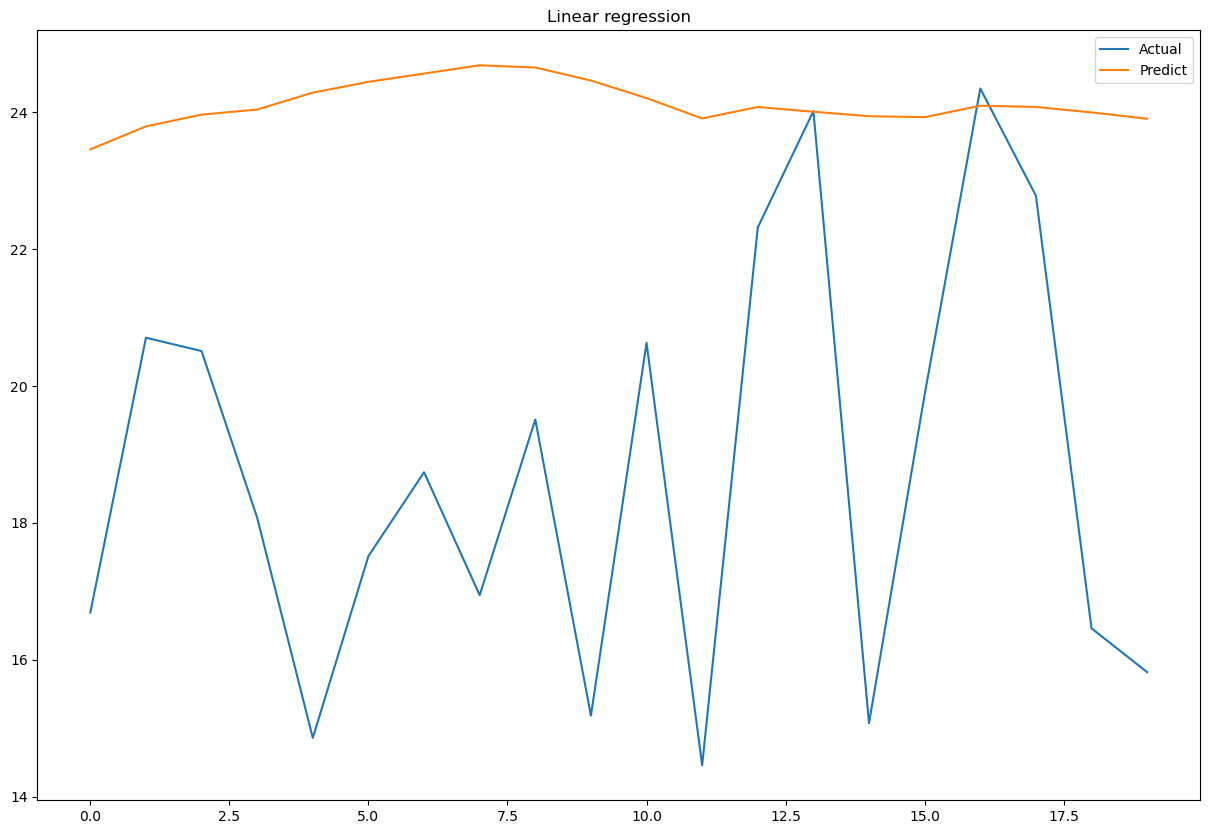

In [86]:
linear_reg_model.fit(X_train,Y_train); 
score = linear_reg_model.score(X_test,Y_test);

predicted= linear_reg_model.predict(X_lately); 

response={};
response['test_score']=score; 
response['predicted_set']=predicted;
print("The test score is: ",format(score))

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)
ax.plot(Y_test[:predict_window],label='Actual')
ax.plot(predicted,label='Predict')
plt.title('Linear regression')
ax.legend()